In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs,make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import NMF
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_lfw_people
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.linear_model import LogisticRegression

import mglearn
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

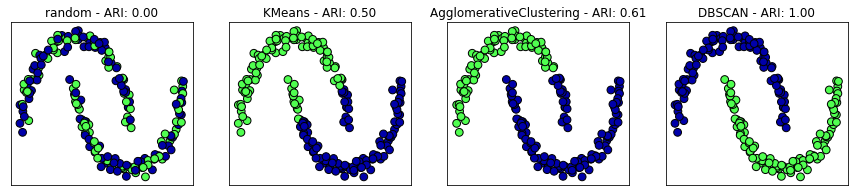

In [6]:
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일을 조정합니다
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 사용할 알고리즘 모델을 리스트로 만듭니다
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# 비교를 위해 무작위로 클러스터 할당을 합니다
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터를 그립니다
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title("random - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # 클러스터 할당과 클러스터 중심을 그립니다
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

- 군집모델을 평가할때 흔히하는 실수
    - adjusted_rand_score나 normaliezed_mutual_info_score와 같은 군집용 측정도구를 사용하지 않고 accuracy_score를 사용하는 것이다.

In [8]:
from sklearn.metrics import accuracy_score

# 포인트가 클러스터로 나뉜 두 가지 경우
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# 모든 레이블이 달라졌으므로 정확도는 0입니다
print("정확도: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# 같은 포인트가 클러스터에 모였으므로 ARI는 1입니다
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

정확도: 0.00
ARI: 1.00


## Evaluating clusters without target values

- ARI를 활용할때는 큰 문제점이 있다.
- 군집 알고리즘을 적용할때 보통 그 결과와 비교할 타깃값이 없다. 
- 데이터가 속한 정확한 클러스터를 알고 있다면 이 정보를 이용해 지도학습 모델을 만들것이다. 
- ARI나 NMI는 애플리케이션의 성능평가가 아닌 알고리즘을 개발할때나 도움이 된다.

-> 이때 실루엣계수를 사용

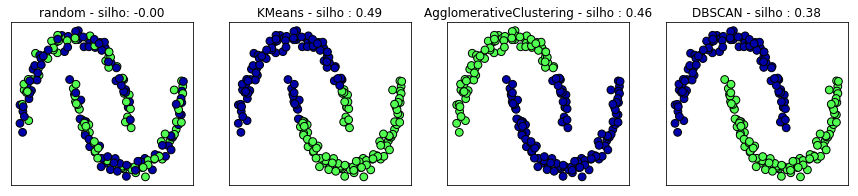

In [14]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일을 조정합니다
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 비교를 위해 무작위로 클러스터 할당을 합니다
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터를 그립니다
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title("random - silho: {:.2f}".format(
        silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # 클러스터 할당과 클러스터 중심을 그립니다
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60, edgecolors='black')
    ax.set_title("{} - silho : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

- 이 내용에서 볼 수 있듯이 DBSCAN의 결과가 더 낫지만 k-평균의 실루엣 점수가 더 높다. 
- 클러스터 평가에 더 적합한 전략은 robusteness base의 지표이다 (견고성기반)
- 데이터에 잡음포인트를 추가하거나 여러가지 매개변수 설정으로 알고리즘을 실행하고 그 결과를 비교 하는 것
- 매게 변수와 데이터에 변화를 주며 반복해도 결과가 일정하다면 신뢰할만하다고 말할 수 있다.

- 군집모델이 매우 안정적이거나 실루엣점수가 높다고 해도